In [1]:
import csv
import pandas
import numpy as np
import seaborn as sns
from scipy import stats
import tensorflow as tf
import chess
import chess.pgn
import pickle
import json

In [2]:
#stockfish = pandas.read_csv('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\stockfish.csv')
#pgn = open('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\data.pgn')
stockfish = pandas.read_csv('/Users/chrisatkeson/Documents/web_project/chess_evaluation/stockfish.csv')
pgn = open('/Users/chrisatkeson/Documents/web_project/chess_evaluation/data.pgn')

In [15]:
with open('chess_positions', mode='w', encoding='utf-8') as f:
    json.dump([], f)

In [3]:
evaluations = stockfish['MoveScores'];
all_evaluations = [];
all_positions =[];

count = 0

for game in evaluations:
    count = count+1
    if count % 500 == 0:
        print(count)
    position = chess.pgn.read_game(pgn)
    for evaluation in game.split():
        all_positions.append(position.board())
        next_position = position.variations[0]
        position = next_position
        if evaluation.isdigit():
            all_evaluations.append(float(evaluation))
        elif evaluation.lstrip('-').isdigit():
            all_evaluations.append(float(evaluation.lstrip('-'))*-1.0)
    if count == 5000:
        break

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [18]:
positions = []
for position in all_positions:
    positions.append(board_encoder(position))

In [29]:
mean_evaluation = np.mean(all_evaluations)
stdeviation = np.std(all_evaluations)
max_evaluation = np.max(all_evaluations)
min_evaluation = np.min(all_evaluations)
max_abs_evaluation = max(max_evaluation, min_evaluation*-1.0)

normalized_evaluations = np.asarray(all_evaluations) * 1/max_abs_evaluation

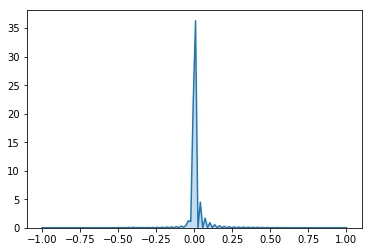

In [17]:
sns.kdeplot(normalized_evaluations[0:100000], shade=True);

In [16]:
#Following Board Representation from Paper
def board_encoder(board):
    bit_boards = {"P": np.zeros(64),"N": np.zeros(64),"B": np.zeros(64),
                  "R": np.zeros(64),"Q": np.zeros(64),"K": np.zeros(64),
                  "p": np.zeros(64),"n": np.zeros(64),"b": np.zeros(64),
                  "r": np.zeros(64),"q": np.zeros(64),"k": np.zeros(64)}
    for i in range(0, 64):
        square = board.piece_at(i)
        if square is not None:
            bit_boards[square.symbol()][i] = 1
            
    bit_board = np.concatenate([bit_boards["P"], bit_boards["R"], bit_boards["N"], bit_boards["B"], 
                                bit_boards["Q"], bit_boards["K"], bit_boards["p"], bit_boards["r"],
                                bit_boards["n"], bit_boards["b"], bit_boards["q"], bit_boards["k"]])
    return bit_board


In [30]:
print(positions[0], normalized_evaluations[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.

In [34]:
# Neural Net
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 500 # 1st layer number of neurons
n_hidden_2 = 500 # 2nd layer number of neurons
n_input = 768 # 12 8x8 chessboards
n_classes = 1 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Create model
def multilayer_perceptron(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [33]:
# Construct model
output = multilayer_perceptron(X)

# using mean squared error cost function
cost  = tf.reduce_mean(tf.square(output - Y))

# using Gradient Descent algorithm
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(positions)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x,
                                                            Y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    pred = tf.nn.softmax(logits)  # Apply softmax to logits
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels}))

In [35]:
with tf.Session() as sess:
    sess.run(init)

    for step in np.arange(training_epochs):
        sess.run(optimizer, feed_dict={X:positions, Y:normalized_evaluations})
        cost_history = np.append(cost_history, sess.run(cost,feed_dict={X:positions, Y:normalized_evaluations}))

    pred_y = sess.run(output, feed_dict={X:positions})
    print (sess.run(output, feed_dict={X:positions}))

# plotting the cost history
plt.plot(range(len(cost_history)), cost_history)
plt.axis([0, epochs, 0, np.max(cost_history)])
plt.show()

ValueError: Cannot feed value of shape (408716,) for Tensor 'Placeholder_3:0', which has shape '(?, 1)'

In [37]:
print(normalized_evaluations)

[0.00145725 0.0013763  0.0009715  ... 0.83273964 0.83273964 0.83330635]
